In [1]:
import os

json_files = [pos_json for pos_json in os.listdir(".") if pos_json.endswith('.json')]

In [22]:
import pandas as pd 

dfs = []
for f in json_files:
    dfs.append(pd.read_json(path_or_buf=f, lines=True))

df = pd.concat(dfs)

In [11]:
for df in dfs:
    print(len(df))

3176
2277
169781


In [3]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/shy/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/shy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/shy/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:
import matplotlib.pyplot as plt
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, MiniBatchNMF, LatentDirichletAllocation
#import sklearn.decomposition

preprocessing_samples = list(filter(lambda x: isinstance(x, str), df['reviewText']))

In [7]:
from tqdm import tqdm
#preprocessing
def lowercasing(data_samples):
  for idx, sample in tqdm(enumerate(data_samples)):
    data_samples[idx] = sample.lower()
  return data_samples

def punctuation_removal(data_samples):
#non-exhaustive; not sure if we want to treat punctuation as significant
#doesn't remove punctuation from inside words
  for i, sample in tqdm(enumerate(data_samples)):
    _sample = sample.split()
    for j, word in enumerate(_sample):
      _sample[j] = word.strip(" .!?@#&():;,'\/\\")
    sample = " ".join(_sample)
    data_samples[i] = sample
  return data_samples

#credit to Selva Prabhakaran
# https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize(data_samples):
  wnl = WordNetLemmatizer()
  for i, sample in tqdm(enumerate(data_samples)):
      _sample = sample.split()
      for j, word in enumerate(_sample):
        tag = get_wordnet_pos(word)
        _sample[j] = wnl.lemmatize(word,tag)
      data_samples[i] = " ".join(_sample)
  return data_samples

preprocessing_samples = lowercasing(preprocessing_samples)
preprocessing_samples = punctuation_removal(preprocessing_samples)
preprocessing_samples = lemmatize(preprocessing_samples)

175060it [00:00, 1708081.86it/s]
175060it [00:00, 222435.69it/s]
175060it [05:02, 579.18it/s] 


In [8]:
preprocessing_samples[0]

'great product and price'

In [9]:
# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(
    max_df=0.01, min_df=2, max_features=n_features, stop_words="english"
)
tf = tf_vectorizer.fit_transform(preprocessing_samples)
tf_vectorizer.stop_words_

Extracting tf features for LDA...


{'b001h9n88y',
 'jezabel',
 'medusa',
 'alexeyevich',
 'cousin',
 'outakes',
 'ignited',
 'b00078v7aw',
 'johnston',
 'disapointment',
 'mism',
 'coupl',
 'auserlesene',
 'hoboken',
 'quake',
 'jubilo',
 'stooge',
 'carves',
 'imna',
 'nightstand',
 'viben',
 'hirten',
 'relaxing',
 'muah',
 'crushes',
 'wordpress',
 'abigail',
 'sugarplum',
 'buh',
 'thorugh',
 'kattan',
 'barstools',
 'interconnect',
 'taft',
 'bu',
 'sepultura',
 'working',
 'ataris',
 'mcd',
 'iyanla',
 'shazzamed',
 'mangling',
 'rollout',
 'xiia',
 'dialed',
 'brand',
 'klman',
 'motive',
 'dweeb',
 'bespectacled',
 'elly',
 'progarchives',
 'sanger',
 'experamentation',
 'coronary',
 'delay',
 'fahey',
 'riffed',
 'hotel',
 'streamline',
 'trusted',
 'sheer',
 'erkel',
 'comfy',
 'colabs',
 'scenario',
 'anachronism',
 'dublin',
 'herd',
 'inventor',
 'b0000013gb',
 'dsjvnv',
 'inhabitions',
 'repetativeness',
 'knowles',
 'liederkreis',
 'illutions',
 'exude',
 'ideal',
 '154',
 'appointment',
 'instrumentality

In [20]:
df['asin'].value_counts()

B00CZF8B68    574
B00BWGHIHY    316
B00136J7ZE    294
B00EH49FRE    283
B00136NUG6    262
             ... 
B000W1S2WU      1
B00125MGQI      1
B001QET6G8      1
B001664ADA      1
B00138APMQ      1
Name: asin, Length: 11797, dtype: int64

In [23]:
n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20
batch_size = 128
init = "nndsvda"

product_id = 'B009MA34NY'
if product_id:
    data_samples = list(filter(lambda x: isinstance(x, str), df[df['asin'] == product_id]['reviewText']))
else:
    data_samples = list(map(lambda x: x['text'], reviews))[:n_samples]


for s in data_samples:

    if not isinstance(s,str):
        print(s)

print(len(data_samples))


375


In [26]:
data_samples = lowercasing(data_samples)
data_samples = punctuation_removal(data_samples)
data_samples = lemmatize(data_samples)
documents = tf_vectorizer.transform(data_samples)

375it [00:00, 833526.23it/s]
375it [00:00, 107516.85it/s]
375it [00:00, 758.86it/s]


Fitting LDA models with tf features, n_samples=2000 and n_features=1000...


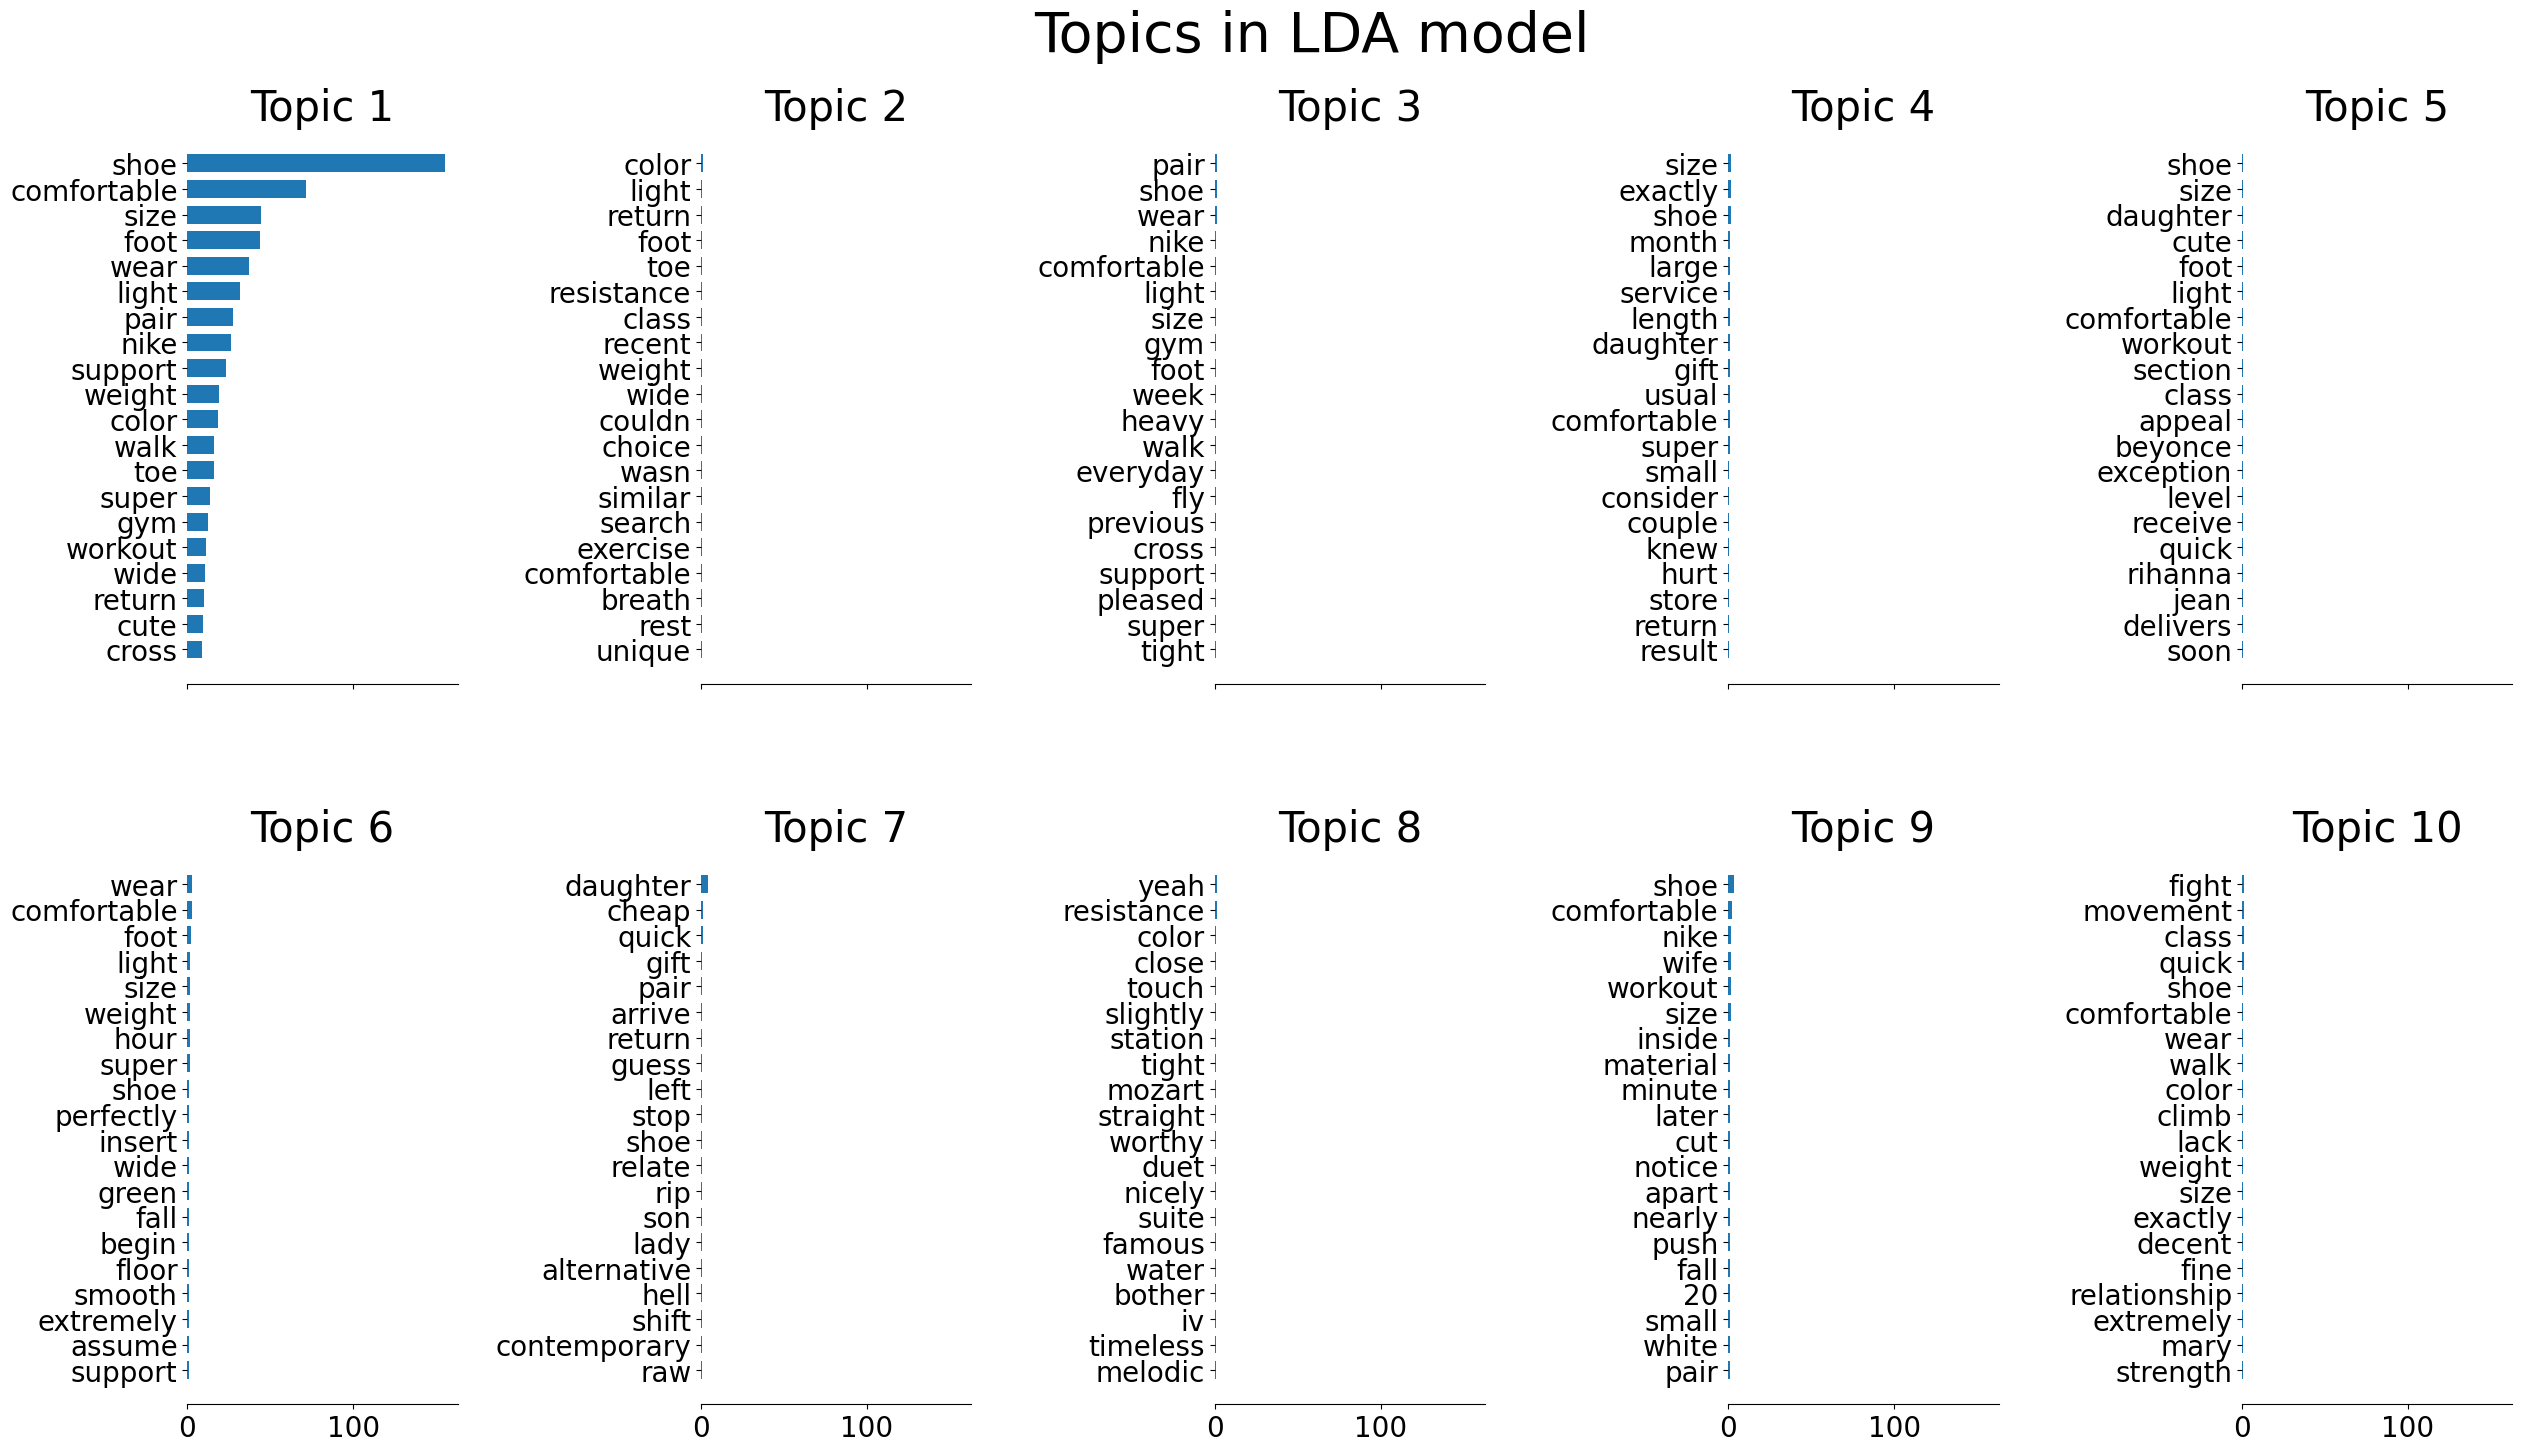

In [27]:
print(
    "Fitting LDA models with tf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
lda.fit(documents)

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")

# Exploration

In [28]:
for i, sample in enumerate(data_samples):
    if len(sample) > 300 and len(sample) < 700:
        print(i,":", sample)

4 : try them on in a store before buying online so i knew they'd fit good overall i be look for a durable cross training shoe that would hold up to my rigorous training and these have be great so far they be really light and comfortable most importantly for me they have grip on the bottom so my foot don't slide out from under me while do plank push-ups etc highly satisfied with this purchase
60 : glad i read the review and order a half size too big these be light weight i work out in them last night and have a great work out they be very comfortable i would recommend these to anyone i be a beach body coach and these be now my new favorite shoe to work out in i feel like i be walk in slipper when i wear these shoe they be so comfortable i love them so much i never buy myself anything nice and for christmas get an amazon gift card and use it to buy myself these sneaker and they be so awesome i really do love them and have be tell all my friend about them get these shoe
62 : i love these 

In [29]:
from nltk import sent_tokenize


raw_reviews = list(filter(lambda x: isinstance(x, str), df[df['asin'] == product_id]['reviewText']))
raw_sentences = sent_tokenize(raw_reviews[337])

processed_sentences = raw_sentences[:]
processed_sentences = lowercasing(processed_sentences)
processed_sentences = punctuation_removal(processed_sentences)
processed_sentences = lemmatize(processed_sentences)

print(raw_sentences)
processed_sentences

3it [00:00, 68015.74it/s]
3it [00:00, 50737.55it/s]
3it [00:00, 423.07it/s]

['Comfortable and lightweight.', "Need a good training shoe that's also supportive and flexible.", 'I really like the fit, but had to get 1/2 size larger as this style in my size is too perfect from heel to toe.']


['comfortable and lightweight',
 "need a good training shoe that's also supportive and flexible",
 'i really like the fit but have to get 1/2 size large a this style in my size be too perfect from heel to toe']

In [30]:
feature_names = tf_vectorizer.get_feature_names_out()
topic_words = []
for topic in lda.components_:
    top_features_ind = topic.argsort()[: -10- 1 : -1]
    topic_words.append([feature_names[i] for i in top_features_ind])
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# TODO: for now compound (a composite score) will suffice. Neutrality (neu) might suggest highly informational content.
for raw, processed in zip(raw_sentences, processed_sentences):
    vs = analyzer.polarity_scores(raw)
    probs = lda.transform(tf_vectorizer.transform([processed]))[0]
    topic = probs.argmax()
    if probs[topic] < 0.2:
        print("{} \n\t overall: {:.2f} neutral: {:.2f}, No Topic\n".format(raw, vs['compound'], vs['neu']))
    else:
        print("{} \n\t overall: {:.2f} neutral: {:.2f}, Topic {}: {}\n".format(raw, vs['compound'], vs['neu'], topic+1, ", ".join(topic_words[topic])))

Comfortable and lightweight. 
	 overall: 0.51 neutral: 0.38, Topic 1: shoe, comfortable, size, foot, wear, light, pair, nike, support, weight

Need a good training shoe that's also supportive and flexible. 
	 overall: 0.72 neutral: 0.50, Topic 1: shoe, comfortable, size, foot, wear, light, pair, nike, support, weight

I really like the fit, but had to get 1/2 size larger as this style in my size is too perfect from heel to toe. 
	 overall: 0.83 neutral: 0.71, Topic 1: shoe, comfortable, size, foot, wear, light, pair, nike, support, weight

